# Sparse Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the sparse dataset. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Sparse Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is woth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. Bellow the dataset for maximum voltage constraints is shown.

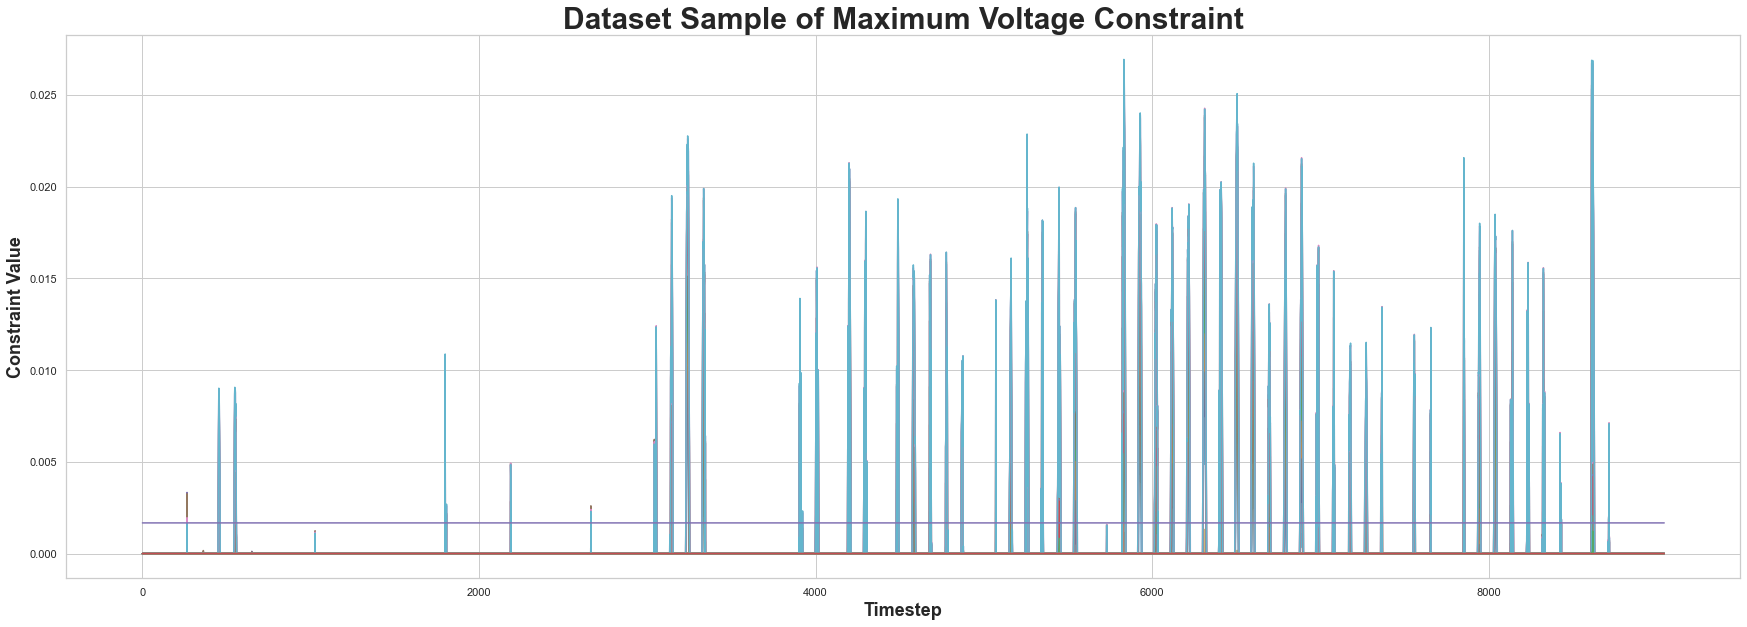

In [1]:
import sys; sys.path.append('..')
from thesis_package import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data, y_max_u)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

The sparse boolean dataset is derived from the one above. It represents the time steps with constraints as of the class 1 and the rest as class 0. This datset is used to train the classification models.

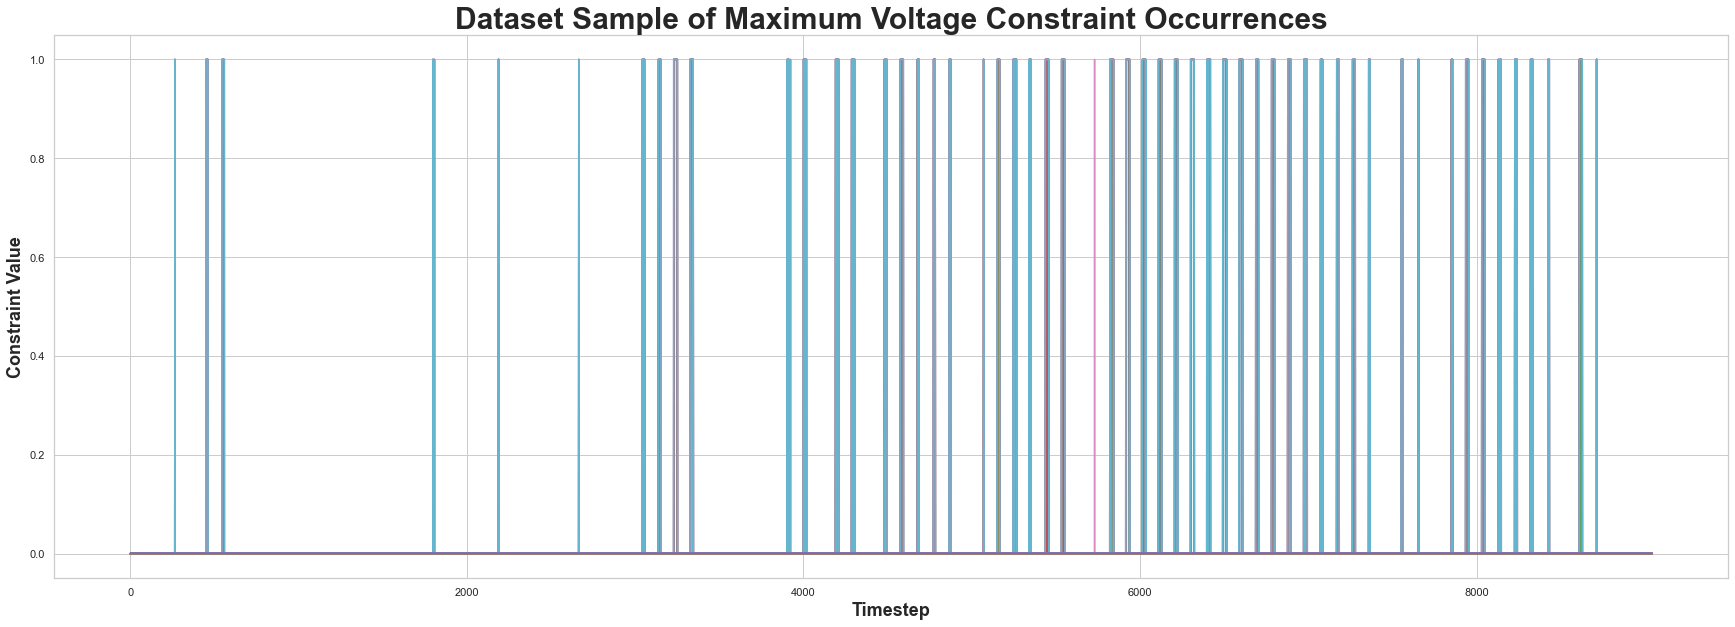

In [2]:
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns='timestamps')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_sparse_bool_train, X_max_u_sparse_bool_test, y_max_u_sparse_bool_train, y_max_u_sparse_bool_test = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool)
data = {'X_train': X_max_u_sparse_bool_train,
        'X_test': X_max_u_sparse_bool_test,
        'y_train': utils.convert_df_to_sparse_bool(y_max_u_sparse_bool_train),
        'y_test': utils.convert_df_to_sparse_bool(y_max_u_sparse_bool_test)}
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_sparse_bool_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint Occurrences', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

However, not all busses have constraints, so it is only possible train classification models for those busses that have positive values in the target dataset.

In [3]:
utils.cols_with_positive_values(y_max_u_sparse_bool)

['bus_8',
 'bus_9',
 'bus_10',
 'bus_11',
 'bus_12',
 'bus_13',
 'bus_14',
 'bus_15',
 'bus_16',
 'bus_18']

## Import Libraries

In [4]:
import optuna 
import os

import numpy as np
import pandas as pd 
import sklearn.metrics
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils, metrics

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [5]:
# General parameters
num_trials = 1

### Extreme Gradient Boosting Regressor

In [ ]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [13]:
# Filtered dataset
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))


[I 2022-09-24 16:57:58,702] A new study created in memory with name: no-name-a2dcd6f3-c2a7-4779-ab18-d9361cf12002
[I 2022-09-24 16:58:46,774] Trial 0 finished with value: 0.11968981470115406 and parameters: {'booster': 'gbtree', 'lambda': 3.0308890881915505e-05, 'alpha': 1.4422072845617444e-07, 'subsample': 0.23290383685359625, 'colsample_bytree': 0.6791483657382902, 'max_depth': 3, 'min_child_weight': 8, 'eta': 8.876596820798085e-07, 'gamma': 0.0031090552512031554, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.11968981470115406.


Number of finished trials:  1
Best trial:
  Value: 0.11968981470115406
  Params: 
    booster: gbtree
    lambda: 3.0308890881915505e-05
    alpha: 1.4422072845617444e-07
    subsample: 0.23290383685359625
    colsample_bytree: 0.6791483657382902
    max_depth: 3
    min_child_weight: 8
    eta: 8.876596820798085e-07
    gamma: 0.0031090552512031554
    grow_policy: lossguide


In [9]:
# FILTERED DATASET
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-24 15:27:44,908] A new study created in memory with name: no-name-72ebed9e-b9ae-4170-a20a-6f935f272250
[I 2022-09-24 15:28:02,303] Trial 0 finished with value: 0.20693524566889948 and parameters: {'booster': 'gblinear', 'lambda': 0.00030859382769665765, 'alpha': 6.885650815527927e-05, 'subsample': 0.21006645462136309, 'colsample_bytree': 0.7835070299895577}. Best is trial 0 with value: 0.20693524566889948.


Number of finished trials:  1
Best trial:
  Value: 0.20693524566889948
  Params: 
    booster: gblinear
    lambda: 0.00030859382769665765
    alpha: 6.885650815527927e-05
    subsample: 0.21006645462136309
    colsample_bytree: 0.7835070299895577


### Gradient Boosting Regressor

In [ ]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
# FILTERED DATA
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [10]:
# FILTERED DATA
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-24 15:31:27,476] A new study created in memory with name: no-name-9bc45578-982c-42cf-868a-76144a2874c2
[I 2022-09-24 15:54:24,116] Trial 0 finished with value: 0.4690849627784803 and parameters: {'n_estimators': 811, 'learning_rate': 0.21921293967356317, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.4690849627784803.


Number of finished trials:  1
Best trial:
  Value: 0.4690849627784803
  Params: 
    n_estimators: 811
    learning_rate: 0.21921293967356317
    loss: absolute_error


### Gradient Boosting Classifier

In [ ]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
    y_max_u_sparse_bool = utils.convert_df_to_sparse_bool(y_max_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the classification performance f1 score
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='micro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
    y_min_u_sparse_bool = utils.convert_df_to_sparse_bool(y_min_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the classification performance f1 score
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='micro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

### Support Vector Regressor

In [ ]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_max_u.columns)
    train_y = pd.DataFrame(train_y, columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_min_u.columns)
    train_y = pd.DataFrame(train_y, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [12]:
# FILTERED DATA
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=utils.cols_with_positive_values(y_max_u))
    valid_y = pd.DataFrame(valid_y, columns=utils.cols_with_positive_values(y_max_u))
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-24 16:15:51,251] A new study created in memory with name: no-name-d595d57a-78bd-45e0-ba6b-750739d1bb53
[I 2022-09-24 16:23:18,393] Trial 0 finished with value: 0.2546963596094271 and parameters: {'kernel': 'rbf', 'C': 0.037303449865448646, 'degree': 3, 'gamma': 0.08715482814241297}. Best is trial 0 with value: 0.2546963596094271.


Number of finished trials:  1
Best trial:
  Value: 0.2546963596094271
  Params: 
    kernel: rbf
    C: 0.037303449865448646
    degree: 3
    gamma: 0.08715482814241297


In [ ]:
# DATA FILTERED
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=utils.cols_with_positive_values(y_min_u))
    train_y = pd.DataFrame(train_y, columns=utils.cols_with_positive_values(y_min_u))
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-23 19:00:04,259] A new study created in memory with name: no-name-b14d31f7-29f2-4146-a45f-b525adca2c39
[I 2022-09-23 19:15:02,741] Trial 0 finished with value: 0.10573808459953839 and parameters: {'kernel': 'poly', 'C': 1.9514168851343338e-07, 'degree': 5, 'gamma': 5.8658412617230567e-08}. Best is trial 0 with value: 0.10573808459953839.


Number of finished trials:  1
Best trial:
  Value: 0.10573808459953839
  Params: 
    kernel: poly
    C: 1.9514168851343338e-07
    degree: 5
    gamma: 5.8658412617230567e-08


### Extreme Gradient Boosting Classifier

In [ ]:
# Same implementation as above, but Extreme Gradient Boosting Classifier.
def objective(trial):
    # import data
    y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
    y_max_u_sparse_bool = utils.convert_df_to_sparse_bool(y_max_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'subsample': trial.suggest_float('subsample', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10)
    }
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
# Same implementation as above, but Extreme Gradient Boosting Classifier.
def objective(trial):
    # import data
    y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
    y_min_u_sparse_bool = utils.convert_df_to_sparse_bool(y_min_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'subsample': trial.suggest_float('subsample', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10)
    }
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

### Support Vector Classifier

In [ ]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
    y_max_u_sparse_bool = utils.convert_df_to_sparse_bool(y_max_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
    y_min_u_sparse_bool = utils.convert_df_to_sparse_bool(y_max_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
import beepy
beepy.beep(6)